In [72]:
import fiftyone as fo
import matplotlib.pyplot as plt
%matplotlib widget 
import numpy as np
import copy

dataset = fo.load_dataset("RumexWeeds")
session = fo.Session(dataset=dataset, auto=False)

In [2]:
#Gets the sequence tags
tags = set()
for x in dataset.values("tags"):
    tags = tags.union(x)

In [3]:
bbox_dict = {}
for tag in tags:
    if "seq" in tag:
        sequence = dataset.match_tags(tag)
        bbox_dict[tag ]= sequence.values("ground_truth_detections.detections.bounding_box")
        break        


In [89]:
class KalmanNd:
    def __init__(self, x_initial, P_initial, H, R, F):
        self.x_initial = x_initial
        self.P_initial = P_initial
        self.x = x_initial # mean_vector (states)
        self.P = P_initial # covariance matrix
        self.H = H #Observability matrix
        self.R = R #Measurement uncertainty
        self.F = F
        self.x_hist = []
        self.P_hist = []
        self.updated = []
        self.locked = False
        self.I = np.zeros((x_initial.shape[0], x_initial.shape[0]))
        np.fill_diagonal(self.I, 1)
    
    def lock(self):
        self.locked = True

    def update(self, Z):
        """Kalman filter measurement update
        Alters the object and updates the Kalman filter with a current measurement.
        Paramaters
        -----------
        Z : ndarray 
            The measurements to use for the update
        """
        if not self.locked:
            y = Z.reshape(-1,1) - np.dot(self.H, self.x)
            S = np.dot(np.dot(self.H,self.P), self.H.T) + self.R
            K = np.dot(np.dot(self.P,self.H.T), np.linalg.pinv(S))
            
            #Removed the update, but rather overwrite the prediction with the update
            self.x_hist[-1] = (copy.deepcopy(self.x))
            self.x = self.x + np.dot(K,y)
            self.P_hist.append(copy.deepcopy(self.P))
            self.P = np.dot((self.I - np.dot(K, self.H)), self.P)
            self.updated[-1] = True
    def predict(self, u=None):
        if not self.locked:
            ### insert predict function
            if u is None:
                u = np.zeros_like(self.x)
            self.x_hist.append(copy.deepcopy(self.x))
            self.x = np.dot(self.F,self.x) + u
            self.P_hist.append(copy.deepcopy(self.P))
            self.P = np.dot(np.dot(self.F, self.P), self.F.T)
            self.updated.append(False)
    def reset(self):
        self.__init__(self.x_initial, self.P_initial, self.H, self.R, self.F)

Given a sequence of frames, make a cv2 video of it:

In [107]:
import cv2 
import time

def draw_boxes(sample, field_color_map, conf_thresh=0.0):
    img = cv2.imread(sample["filepath"])
    for field in field_color_map.keys():
        if sample[field] is not None:
            for gt in sample[field].detections:
                tl_x = int(gt.bounding_box[0]*sample["metadata"].width)
                tl_y = int(gt.bounding_box[1]*sample["metadata"].height)
                br_x = int(tl_x + gt.bounding_box[2]*sample["metadata"].width)
                br_y = int(tl_y + gt.bounding_box[3]*sample["metadata"].height)
                if gt.confidence is not None:
                    if gt.confidence > conf_thresh:
                        img = cv2.rectangle(img, (tl_x, tl_y), (br_x, br_y), field_color_map[field], 5)
                else:
                    img = cv2.rectangle(img, (tl_x, tl_y), (br_x, br_y), field_color_map[field], 5)

    return img


def plot_points(canvas, points):
    if len(points) > 1:
        
        #Normalize the coordinates, first find max and min
        max_x = max(points, key=lambda x:x[0])[0]
        max_y = max(points, key=lambda x:x[1])[1]
        min_x = min(points, key=lambda x:x[0])[0]
        min_y = min(points, key=lambda x:x[1])[1]

        #Scaling factors for the length of each axis
        #A point's difference to the maximum of each axis is to be scaled
        x_scale = canvas.shape[0] / (max_x - min_x)
        y_scale = canvas.shape[1] / (max_y - min_y)

        for point in points:
            canvas = cv2.circle(canvas, (int((max_x-point[0])*x_scale), int((max_y - point[1])*y_scale)), 3, (0,0,255), cv2.FILLED)
    else:
        #Draw point
        canvas = cv2.circle(canvas, [x//2 for x in canvas.shape[:2]], 3, (0,0,1), cv2.FILLED)
    return canvas


cv2.namedWindow("test", cv2.WINDOW_NORMAL)
sequence = dataset.match_tags("20210806_hegnstrup_seq11")
traj = []
kmf = KalmanNd(np.asarray([[0], [0], [0], [0]]), 
                        1000*np.eye(4),
                        np.asarray([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]]),
                        np.asarray([[0.2, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0.2, 0], [0, 0, 0, 0]]),
                        np.asarray([[1, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 1], [0, 0, 0, 1]]))

for frame in sequence:
    load_time = time.time()
    img = draw_boxes(frame, {"ground_truth_detections_single" : (255,0,0),  "predictions_yolov4_csp_single" : (0,255,0)}, 0.5)
    
    #Use OpenCV to plot GPS path
    canvas = np.zeros((1000,1000,3), dtype=np.uint8)
    traj.append(frame["location"].point)
    canvas = plot_points(canvas, traj)
    
    #Kalman filter prediction
    kmf.predict()

    if frame["ground_truth_detections_single"] is not None:
        box = frame["ground_truth_detections_single"].detections[0].bounding_box
        center = (box[0] + 0.5*box[2], box[1] + 0.5*box[3])
        if np.random.binomial(1, 0.5, 1):
            kmf.update(np.asarray([center[0], 0, center[1], 0]).reshape(-1,1))
            
            #Draw update point
            cv2.circle(img, (int(center[0]*frame["metadata"].width), int(center[1]*frame["metadata"].height)), 10, (0,255, 0), cv2.FILLED)

    canvas = np.pad(canvas, ((100,100), (460, 460), (0,0)), 'constant', constant_values=((0,0),(0,0),(0,0)))

    #Draw kalman filter point on image
    cv2.circle(img, (int(kmf.x_hist[-1][0]*frame["metadata"].width), int(kmf.x_hist[-1][2]*frame["metadata"].height)), 10, ((255, 0, 0) if kmf.updated[-1] else (0,0,255)), cv2.FILLED)
    img = np.hstack((img, canvas))
    cv2.imshow("test", img)
    key = cv2.waitKey(max(1, int(abs(2 - (time.time() - load_time)))*1000))
    #time.sleep(min(0, abs(5 - (time.time() - load_time))))

cv2.destroyAllWindows()

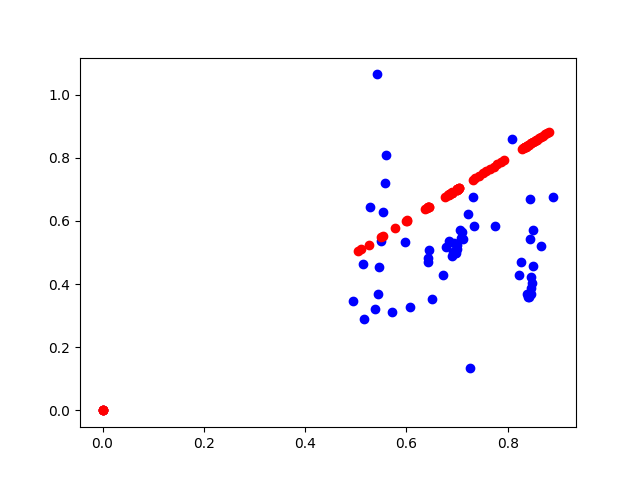

In [103]:
state_array = np.squeeze(np.asarray(kmf.x_hist))
plt.figure()
plt.scatter(state_array[np.asarray(kmf.updated), 0], state_array[np.asarray(kmf.updated), 2], color="blue")
plt.scatter(state_array[~np.asarray(kmf.updated), 0], state_array[~np.asarray(kmf.updated), 0], color="red")


In [97]:
np.asarray(kmf.updated)

array([False, False, False, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
       False,  True, False, False,  True,  True,  True,  True, False,
       False,  True,  True, False,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False,  True, False,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False,  True, False,
       False, False,  True, False, False, False, False,  True,  True,
       False,  True, False,  True,  True, False,  True,  True,  True,
       False, False, False, False,  True, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,

In [62]:
img = cv2.imread(frame["filepath"])
img[0, 0, :]
canvas[0,0, :].dtype

dtype('float64')

/home/pat/anaconda3/envs/YOLOx/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


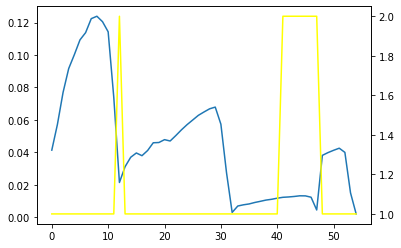

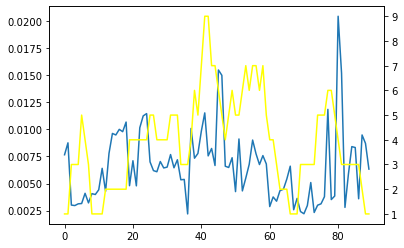

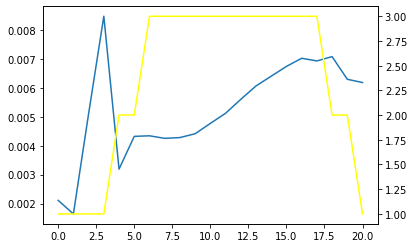

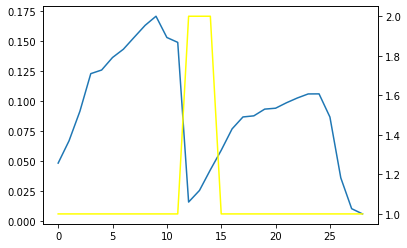

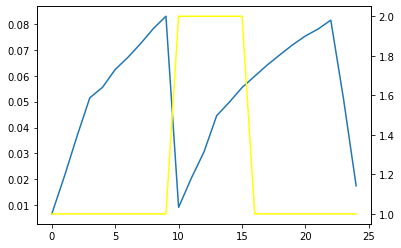

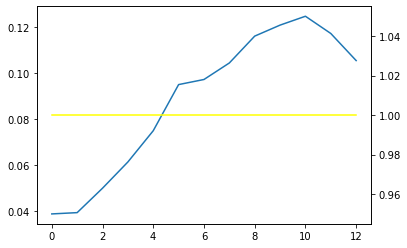

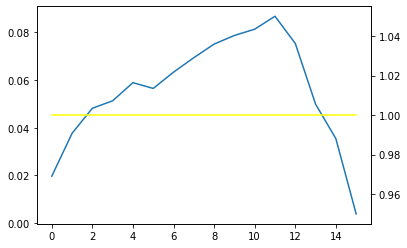

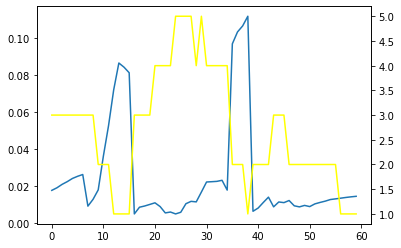

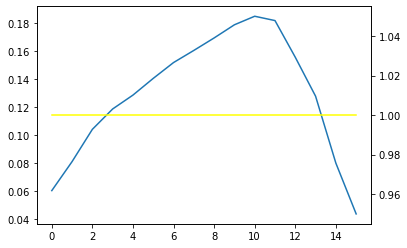

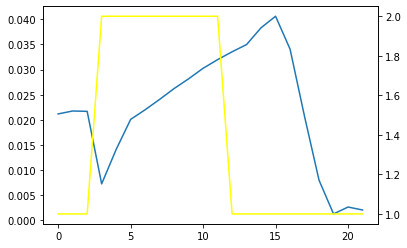

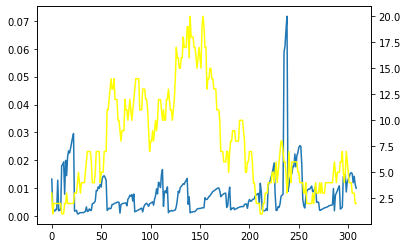

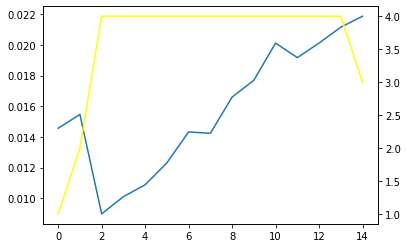

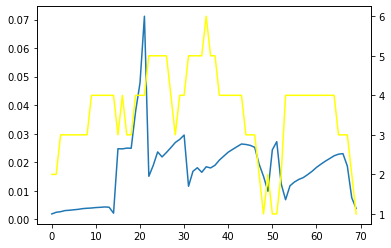

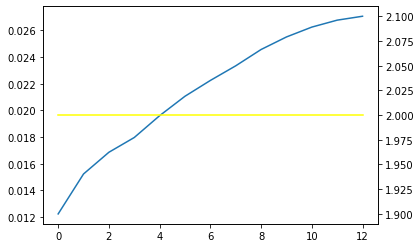

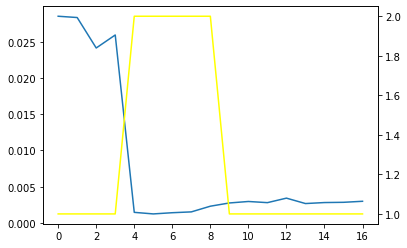

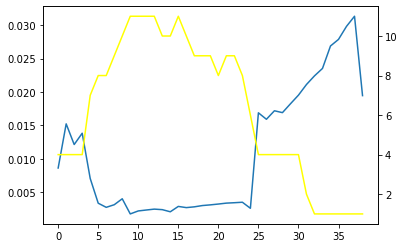

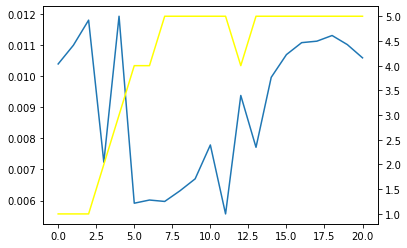

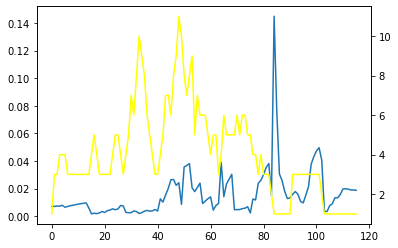

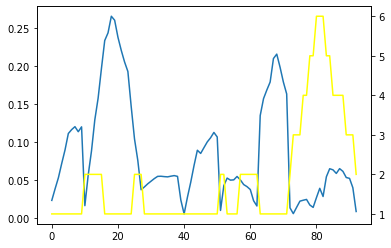

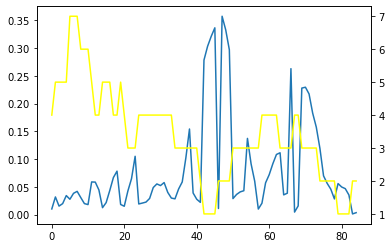

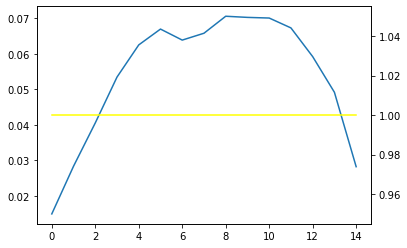

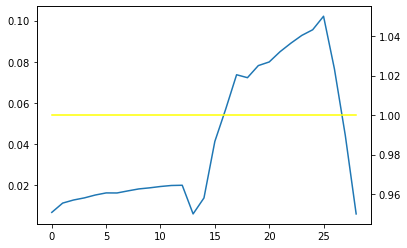

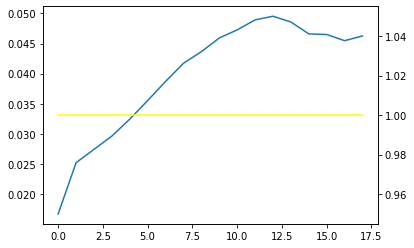

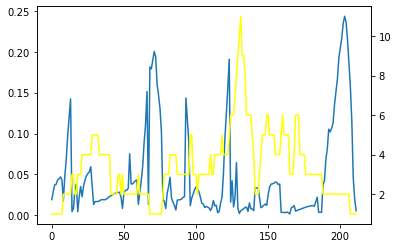

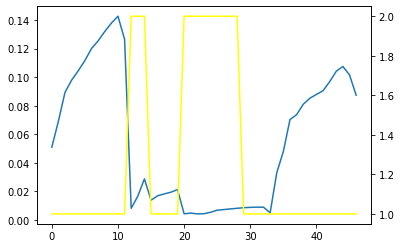

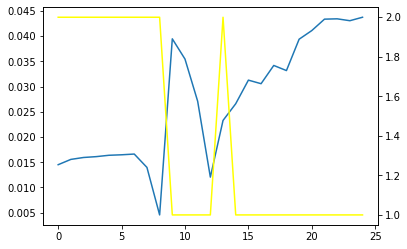

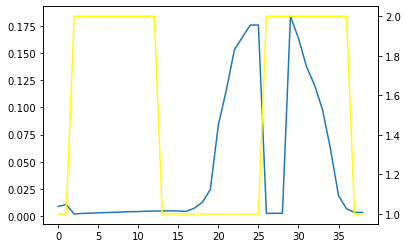

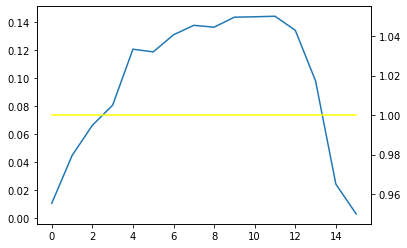

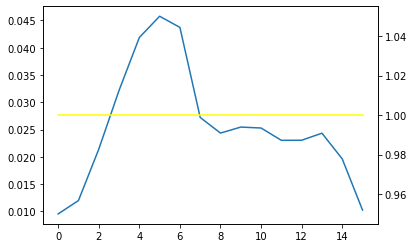

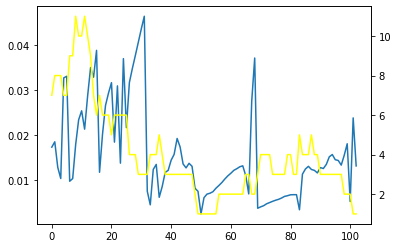

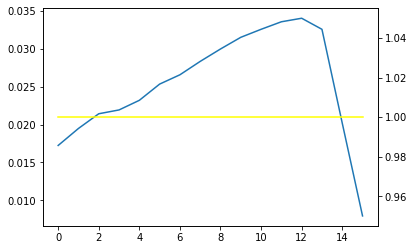

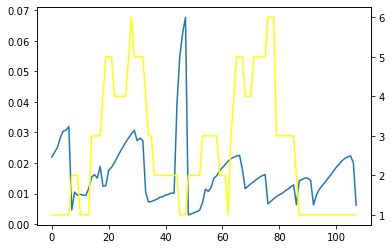

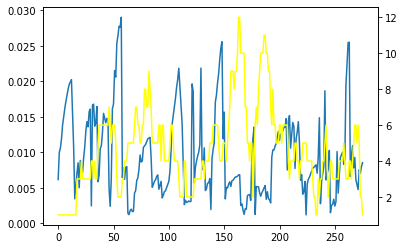

Error in callback <function flush_figures at 0x7fe564d5c7a0> (for post_execute):


KeyboardInterrupt: 

In [77]:
area_fn = lambda x: x[2]*x[3]
for key in bbox_dict:
    area = []
    box_count = []
    detections = bbox_dict[key]
    fig = plt.figure()
    ax = plt.axes()
    for detection in detections:
        if detection is not None:
            bbox_array = np.asarray(detection).reshape(-1,4)
            area.append(np.cumsum(np.apply_along_axis(area_fn, 1, bbox_array)[-1]))
            box_count.append(bbox_array.shape[0])
    ax.plot(area)
    ax.twinx().plot(box_count, color='yellow')
        